In [1]:
### THA DAILY MODES COMPARING

In [2]:
### MODULES IMPORT

import pandas as pd
import numpy as np
from datetime import date, datetime
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
### GENERAL PARAMETERS INITIALIZATION

### Common constants:
All = slice(None)
### Data loading paths:
str_path_bb_hdf = 'Data_Files/Source_Files/Bloomberg_prepared.h5'
str_key_ret_monthly = 'bb_ret_monthly'
str_key_mcap = 'bb_mcap'
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'

In [4]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE

def ison_membership_converting(str_path_universe, date_end):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(io = str_path_universe, sheet_name = 0, header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index()    
    ### Results output:
    return ser_res_universe

In [5]:
### DEFINING MEASURE STATISTICS CALCULATOR

def measure_stats(df_measures, arr_back_period = [99]):
    ### Declaring local constants & variables:
    dict_stats = {}
    ### Stats calculating:
    for iter_measure in df_measures.columns:
        dict_period = {}
        for iter_back_period in arr_back_period:
            ser_iter_measure = df_measures[iter_measure].dropna()
            idx_iter_range = pd.date_range(end = ser_iter_measure.index[-1], periods = iter_back_period * 12, freq = 'BM')
            ser_iter_measure = ser_iter_measure[idx_iter_range]            
            ser_iter_stats = pd.Series()
            ser_iter_stats['count'] = ser_iter_measure.count()
            ser_iter_stats['min'] = ser_iter_measure.min()
            ser_iter_stats['max'] = ser_iter_measure.max()        
            ser_iter_stats['mean'] = ser_iter_measure.mean()
            ser_iter_stats['std'] = ser_iter_measure.std()
            ser_iter_stats['median'] = ser_iter_measure.median()        
            ser_iter_stats['perc_25'] = ser_iter_measure.quantile(0.25, 'midpoint')
            ser_iter_stats['perc_75'] = ser_iter_measure.quantile(0.75, 'midpoint')
            ser_iter_stats['iq_range'] = ser_iter_measure.quantile(0.75, 'midpoint') - ser_iter_measure.quantile(0.25, 'midpoint')
            ser_iter_stats['mean_abs'] = ser_iter_measure.abs().mean()
            ser_iter_stats['t_stat'] = (ser_iter_measure.mean() / ser_iter_measure.std()) * np.sqrt(ser_iter_measure.count())  
            dict_period[iter_back_period] = ser_iter_stats
        dict_stats[iter_measure] = pd.concat(dict_period, axis = 1)
    ### Preparing results:
    return pd.concat(dict_stats, axis = 1)

In [6]:
### DEFINING EFFICACY MEASURES FOR SINGLE FACTOR

def single_factor_multiple_efficacy_measures(ser_factor, ser_return, ser_weight, arr_measure, return_shift = 0, arr_truncate = [2.5, 2.0]):
    ### Declaring local constants & variables:
    All = slice(None)
    dict_measure = {}
    set_std_needed = {'fmb_std_eqw', 'fmb_std_weighted'}
    num_precision = 5 # For quintile bins rounding and borders controlling
    ### Defining date index shifting function:
    def date_reindex(iter_group, idx_date_range, return_shift = 0):
        ser_iter_result = iter_group.unstack('Country').reindex(idx_date_range).sort_index().shift(-return_shift).stack('Country', dropna = False).squeeze()
        ### Results output:
        return ser_iter_result    
    ### Defining MatLab style prctile function:
    def prctile(ser_to_perc, p):
        ### Sorted list preparing:
        list_to_perc = ser_to_perc.dropna().values
        list_sorted = np.sort(list_to_perc)
        ### Length calculating:
        num_len = len(list_to_perc)    
        ### Prctile calculating:
        num_result = np.interp(np.array(p), np.linspace(1 / (2 * num_len), (2 * num_len - 1) / (2 * num_len), num_len), list_sorted)
        ### Results output:
        return num_result
    ### Defining quintile bins distribution:
    def quintile_distribution(ser_iter_group, num_bins = 5, bool_right_included = True, bool_include_lowest = True, bool_populate_last = True):
        ### Bins preparing:
        list_bin = list(np.arange(0, 100, 100 / num_bins))[1 : ]
        list_bin = [round(iter_element / 100, 2) for iter_element in list_bin]
        list_bin = [prctile(ser_iter_group, iter_element) for iter_element in list_bin]
        list_bin = [ser_iter_group.min() - abs(ser_iter_group.min())] + list_bin + [ser_iter_group.max() + abs(ser_iter_group.max())]
        list_bin = [round(iter_element, num_precision) for iter_element in list_bin]
        if bool_populate_last:
            list_bin[-2] -= 10 ** (-num_precision)
        ### Bins distribution:
        ser_iter_distribution = pd.cut(ser_iter_group, bins = list_bin, labels = range(num_bins), 
                                       right = bool_right_included, include_lowest = bool_include_lowest, precision = num_precision)
        ### Results output:
        return ser_iter_distribution    
    ### Defining get_measure group level function:
    def get_measure(df_to_measure, iter_measure):
        ### Checking data sufficiency:
        if (len(df_to_measure.dropna().index) > 1):           
            ### Measure calculating:
            if (iter_measure == 'ic_spearman'):
                ### Spearmen information coefficient:
                list_factor = df_to_measure[['Factor', 'Return']].dropna()['Factor'].values
                list_return = df_to_measure[['Factor', 'Return']].dropna()['Return'].values
                num_result = ss.spearmanr(list_factor, list_return, nan_policy = 'omit').correlation
            if (iter_measure == 'ic_pearson'):
                ### Pearson information coefficient:
                list_factor = df_to_measure[['Factor', 'Return']].dropna()['Factor'].values
                list_return = df_to_measure[['Factor', 'Return']].dropna()['Return'].values                
                num_result = ss.pearsonr(list_factor, list_return)[0]
            if (iter_measure == 'fmb_eqw'):
                ### Fama-McBeth cross-sectional regression beta coefficient (equal weighted residuals):
                list_factor_added = df_to_measure[['Factor', 'Constant', 'Return']].dropna()[['Factor', 'Constant']].values
                list_return = df_to_measure[['Factor', 'Constant', 'Return']].dropna()['Return'].values
                wls_model = sm.OLS(endog = list_return, exog = list_factor_added, missing = 'drop', hasconst = False)
                wls_results = wls_model.fit()
                num_result = wls_results.params[0]
            if (iter_measure == 'fmb_weighted'):
                ### Fama-McBeth cross-sectional regression beta coefficient (market capitalization weighted residuals):
                list_factor_added = df_to_measure[['Factor', 'Constant', 'Return', 'Weight']].dropna()[['Factor', 'Constant']].values
                list_return = df_to_measure[['Factor', 'Constant', 'Return', 'Weight']].dropna()['Return'].values                
                list_weight = df_to_measure[['Factor', 'Constant', 'Return', 'Weight']].dropna()['Weight'].values
                wls_model = sm.WLS(endog = list_return, exog = list_factor_added, weights = pow(list_weight, 1/2), missing = 'drop', hasconst = False)
                wls_results = wls_model.fit()
                num_result = wls_results.params[0]
            if (iter_measure == 'fmb_std_eqw'):             
                ### Fama-McBeth cross-sectional regression beta coefficient (market capitalization weighted residuals):
                list_factor_std_added = df_to_measure[['Factor_std', 'Constant', 'Return']].dropna()[['Factor_std', 'Constant']].values
                list_return = df_to_measure[['Factor_std', 'Constant', 'Return']].dropna()['Return'].values                
                wls_model = sm.OLS(endog = list_return, exog = list_factor_std_added, missing = 'drop', hasconst = False)
                wls_results = wls_model.fit()
                num_result = wls_results.params[0]                 
            if (iter_measure == 'fmb_std_weighted'):
                ### Fama-McBeth cross-sectional regression beta coefficient (market capitalization weighted residuals):
                list_factor_std_added = df_to_measure[['Factor_std', 'Constant', 'Return', 'Weight']].dropna()[['Factor_std', 'Constant']].values
                list_return = df_to_measure[['Factor_std', 'Constant', 'Return', 'Weight']].dropna()['Return'].values                
                list_weight = df_to_measure[['Factor_std', 'Constant', 'Return', 'Weight']].dropna()['Weight'].values                
                wls_model = sm.WLS(endog = list_return, exog = list_factor_std_added, weights = pow(list_weight, 1/2), missing = 'drop', hasconst = False)
                wls_results = wls_model.fit()
                num_result = wls_results.params[0]  
            if (iter_measure == 'clp'):
                ### Constant leverage portfolio signed normalized multiplication sum:                
                ser_clp_weighted = df_to_measure[['Factor', 'Return', 'Weight']].dropna()['Factor']
                ser_clp_weighted = ser_clp_weighted * df_to_measure[['Factor', 'Return', 'Weight']].dropna()['Weight'].transform(np.sqrt)
                ser_clp_weighted.loc[ser_clp_weighted < 0] = -ser_clp_weighted / ser_clp_weighted[ser_clp_weighted < 0].sum()
                ser_clp_weighted.loc[ser_clp_weighted > 0] = ser_clp_weighted / ser_clp_weighted[ser_clp_weighted > 0].sum()
                num_result = (ser_clp_weighted * df_to_measure['Return']).sum()
            if ('qtl' in iter_measure):
                ### Interquntile range:
                num_bins = int(iter_measure.split('qtl')[1])   
                df_to_measure = df_to_measure[['Factor', 'Return', 'Constant']].dropna()
                df_to_measure['Return'] = df_to_measure['Return'] - df_to_measure['Return'].mean()
                df_to_measure['Factor'] = df_to_measure['Factor'].round(num_precision)
                ### Distribution factor values between quintile bins:
                ser_qtl_bins = quintile_distribution(df_to_measure['Factor'], num_bins, bool_right_included = True, bool_include_lowest = True, bool_populate_last = True)
                ser_qtl_bins.name = 'Bin'
                ### Mean return for each bin calculating:
                df_to_measure = df_to_measure.join(ser_qtl_bins)
                df_qtl_rets = df_to_measure.loc[(All), ['Return', 'Bin']]
                df_qtl_rets.set_index('Bin', append = True, inplace = True)
                ser_qtl_rets = df_qtl_rets.unstack('Bin').mean(axis = 0).droplevel(0).squeeze()
                num_result = ser_qtl_rets.iloc[-1] - ser_qtl_rets.iloc[0]                                 
        else:                          
            num_result = np.NaN
        ### Preparing results: 
        return num_result
    ### Preparing combined vectors for measures calculating:
    if (ser_weight.count() == 0):
        ser_weight = pd.Series(1, index = ser_factor.index)
    ### Region filter dropping:
    ser_factor = ser_factor.reset_index('Market', drop = True)
    ser_return = ser_return.reset_index('Market', drop = True)
    ser_weight = ser_weight.reset_index('Market', drop = True)
    ### Preparing shifted returns:
    idx_date_range = ser_return.index.get_level_values(0).unique()
    ser_return_shifted = ser_return.groupby('Country', group_keys = False).apply(date_reindex, idx_date_range, return_shift)
    ### Preparing combined vectors for measures calculating:
    df_to_measure = pd.concat([ser_factor, ser_return_shifted, ser_weight], axis = 1)
    df_to_measure.columns = ['Factor', 'Return', 'Weight']
    df_to_measure['Constant'] = 1
    if set_std_needed.intersection(set(arr_measure)):
        ser_factor_std = df_to_measure.dropna()['Factor'].groupby('Date').apply(ison_standartize, arr_truncate = arr_truncate, within_market = False)
        df_to_measure['Factor_std'] = ser_factor_std.reindex(df_to_measure.index)
    ### Looping efficacy measures for calculating measures timeseries:
    for iter_measure in arr_measure:
        dict_measure[iter_measure] = df_to_measure.groupby('Date').apply(get_measure, iter_measure = iter_measure)
    ### Preparing results:
    return pd.concat(dict_measure, axis = 1)

In [7]:
### DEFINING SINGLE EFFICACY MEASURE FOR MULTIPLE FACTORS
    
def multiple_factor_single_efficacy_measure_stats(df_factors, ser_return, ser_weight, str_measure, num_back_period = 99, 
                                                  num_horizon = 12, list_region_xmo = ['DM', 'EM', 'FM']): 
    ### Declaring local constants & variables:
    All = slice(None)
    list_months = [1, 2, 3, 6, 9 ,12]
    list_range = [iter_month - 1 for iter_month in list_months if iter_month <= num_horizon]
    ### Defining full universe expanding for date:
    def universe_reindex(iter_group, idx_universe):
        df_iter_result = iter_group.unstack('Date').reindex(idx_universe).sort_index().stack('Date', dropna = False)
        ### Results output:
        return df_iter_result   
    ### Defining date index shifting function:
    def date_reindex(iter_group, idx_date_range, return_shift = 0):
        ser_iter_result = iter_group.unstack('Country').reindex(idx_date_range).sort_index().shift(-return_shift).stack('Country', dropna = False).squeeze()
        ### Results output:
        return ser_iter_result   
    ### Defining by date correrlation function:
    def corr_by_date(iter_group):
        num_iter_corr = iter_group['Corr_factor_minus'].corr(iter_group['Corr_factor_plus'])
        ### Results output:
        return num_iter_corr       
    ### Preparing expanded universe for autocorrelation performing:
    df_factors_region = df_factors.loc[(All, All, list_region_xmo), :]
    idx_date_range = df_factors_region.index.get_level_values(0).unique()
    idx_universe = df_factors_region.index.get_level_values(1).unique()
    df_factors_full = df_factors_region.reset_index('Market', drop = True).groupby('Date', group_keys = False).apply(universe_reindex, idx_universe).swaplevel()
    ### Factors looping:
    dict_factors_measures = {} ### Container for all factor measure stats
    dict_factors_vectors = {} ### Container for all factor measure vectors
    dict_factors_autocorr = {} ### Container for autocorrelation results
    for iter_factor in df_factors.columns:
        ### Shifts looping for factors measures stats:
        ### Stats calculation:
        dict_factor_stats = {} ### Container for iterated factor stats
        dict_factor_vectors = {} ### Container for iterated factor measure vectors
#        for iter_shift in range(num_horizon):
        for iter_shift in list_range:            
#            df_factor_filtered = df_factors[iter_factor].loc[All, All, list_region_xmo]
            df_factor_filtered = df_factors_region[iter_factor]
            df_iter_shift_measure = single_factor_multiple_efficacy_measures(df_factor_filtered, ser_return, ser_weight, [str_measure], iter_shift, list_truncate)
            df_iter_shift_stats = measure_stats(df_iter_shift_measure, [num_back_period])
            dict_factor_stats[iter_shift] = df_iter_shift_stats.loc[['mean', 't_stat'], (str_measure, num_back_period)]
            dict_factor_vectors[iter_shift] = df_iter_shift_measure
        ### Aggegating factor measure stats:
        df_iter_factor_stats = pd.concat(dict_factor_stats, axis = 1)
        df_iter_factor_stats.columns = df_iter_factor_stats.columns + 1        
        dict_factors_measures[iter_factor] = df_iter_factor_stats
        ### Aggegating factor measure vectors:        
        df_iter_factor_vectors = pd.concat(dict_factor_vectors, axis = 1)    
        df_iter_factor_vectors.columns = df_iter_factor_vectors.columns.droplevel(1) + 1
        dict_factors_vectors[iter_factor] = df_iter_factor_vectors        
        ### Autocorrelation calculation:
        ser_iter_factor = df_factors_full[iter_factor]
        ser_iter_factor_plus = ser_iter_factor.groupby('Country', group_keys = False).apply(lambda iter_group: iter_group.iloc[1 : ]).\
                                sort_index(level = ['Date', 'Country'])
        ser_iter_factor_minus = ser_iter_factor.groupby('Country', group_keys = False).apply(lambda iter_group: iter_group.iloc[: -1]).\
                                sort_index(level = ['Date', 'Country'])
        ### Artificial series combining for indexes synchronization:        
        ser_iter_factor_plus_shifted = ser_iter_factor_plus.groupby('Country', group_keys = False).apply(date_reindex, idx_date_range, 1)
        df_iter_factor_to_corr = pd.concat([ser_iter_factor_minus, ser_iter_factor_plus_shifted], axis = 1)
        df_iter_factor_to_corr.columns = ['Corr_factor_minus', 'Corr_factor_plus']
        dict_factors_autocorr[iter_factor] = pd.Series(df_iter_factor_to_corr.groupby('Date').apply(corr_by_date).mean(), index = ['autocorr'])
    ### Results output:
    df_factors_measures_stats = pd.concat(dict_factors_measures, axis = 0)
    df_factors_autocorr =  pd.concat(dict_factors_autocorr, axis = 1).transpose()
    df_factors_vectors = pd.concat(dict_factors_vectors, axis = 0)
#    df_factors_coeff = df_factors_measures_stats.loc[(All, 'mean'), list_months].reset_index(1, drop = True)
    df_factors_coeff = df_factors_measures_stats.loc[(All, 'mean'), All].reset_index(1, drop = True)    
    df_factors_coeff.columns = [('coeff_' + str(iter_column)) for iter_column in df_factors_coeff.columns]
#    df_factors_t_stat = df_factors_measures_stats.loc[(All, 't_stat'), list_months].reset_index(1, drop = True)
    df_factors_t_stat = df_factors_measures_stats.loc[(All, 't_stat'), All].reset_index(1, drop = True)    
    df_factors_t_stat.columns = [('t_' + str(iter_column)) for iter_column in df_factors_t_stat.columns]
    df_factors_result = pd.concat([df_factors_autocorr, df_factors_coeff, df_factors_t_stat], axis = 1)    
    return (df_factors_result, df_factors_vectors)

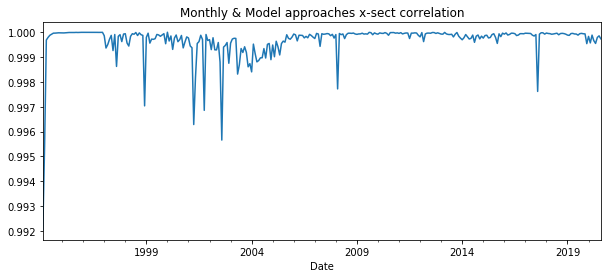

In [11]:
### TEST: FACTOR CORRELATION

### Factors loading:
ser_factor_monthly = pd.read_csv('Data_Files/Test_Files/acadian_mode_test_factor_agg_monthly.csv', sep = ';', header = 0, index_col = [0, 1, 2], parse_dates = [0],
                                 squeeze = True, keep_default_na = False, na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                                                       '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'])
ser_factor_monthly.name = 'Monthly'
ser_factor_model = pd.read_csv('Data_Files/Test_Files/acadian_mode_test_factor_agg_model.csv', sep = ';', header = 0, index_col = [0, 1, 2], parse_dates = [0],
                                 squeeze = True, keep_default_na = False, na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                                                       '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'])
ser_factor_model.name = 'Model'
### Algorythms cross-sectional correlation:
df_factors = pd.concat([ser_factor_monthly, ser_factor_model], axis = 1)
ser_x_sect_corr = df_factors.droplevel('Market').groupby('Date').corr().loc[(All, 'Model'), 'Monthly'].droplevel(-1)
ser_x_sect_corr[1 : ].plot(figsize = (10, 4), title = 'Monthly & Model approaches x-sect correlation')
plt.show()

In [9]:
### TEST: EFFICACY COMPARING PREPARATIONS

### Measures parameters:
list_measure = ['fmb_weighted'] # Efficacy measures list
list_back_period = [99, 10, 5] # Look back periods
int_horizon = 12 # Measure stats horizon
list_ison = ['DM', 'EM', 'FM'] ### Region filter
list_truncate = [2.5, 2.0] # Standartization boundaries
bool_within_market = True # Standartization way
### ISON universe loading:
ser_ison = ison_membership_converting(str_path_universe, '2020-07-31') 
### Returns loading:
ser_returns = pd.read_hdf(str_path_bb_hdf, key = str_key_ret_monthly).loc[['USD'], All, All].droplevel('Currency') ### 
ser_returns = ser_returns.groupby('Country').shift(periods = -1).to_frame().join(ser_ison, how = 'left').set_index('Market', append = True).squeeze()
ser_returns = ser_returns.loc[All, All, list_ison]
### Market caps loading:
ser_mcap = pd.read_hdf(str_path_bb_hdf, key = str_key_mcap).loc[All, All, list_ison]

In [10]:
### TEST: EFFICACY CALCULATING

### Results container:
dict_measure_stats = {}
dict_measure_vectors = {}
### Algorythms looping:
for iter_factor in df_factors.columns:
    ### Region groups looping:
    for iter_region in [['DM', 'EM', 'FM'], ['DM'], ['EM'], ['FM']]: # [['DM', 'EM', 'FM']]: # ['DM']: # ['EM']: # ['FM']: #
        ### Iteration ID generating:
        str_iter_id = iter_factor + '__' + '_'.join(iter_market for iter_market in iter_region)
        print(str_iter_id)
        ### Measure calculating:
        dict_measure_stats[str_iter_id], dict_measure_vectors[str_iter_id] = multiple_factor_single_efficacy_measure_stats(df_factors[iter_factor].to_frame(), 
                                                                                                                           ser_returns * 100, 
                                                                                                                           ser_mcap,
                                                                                                                           list_measure[0], 
                                                                                                                           list_back_period[0], 
                                                                                                                           int_horizon, 
                                                                                                                           iter_region)      

Monthly__DM_EM_FM
Monthly__DM
Monthly__EM
Monthly__FM
Model__DM_EM_FM
Model__DM
Model__EM
Model__FM


In [13]:
### TEST: EFFICACY COMPARING

### Results preparing (stats):
df_factor_measure_stats = pd.concat(dict_measure_stats).droplevel(1)
df_factor_measure_stats.index.name = 'KEY'
df_factor_measure_stats.reset_index(inplace = True)
df_factor_measure_stats['Algorythm'] = df_factor_measure_stats['KEY'].str.split('__').str[0]
df_factor_measure_stats['Region'] = df_factor_measure_stats['KEY'].str.split('__').str[1]
df_factor_measure_stats = df_factor_measure_stats.set_index(['Algorythm', 'Region']).drop('KEY', axis = 1)
#df_factor_measure_stats.to_excel('Data_Files/Test_Files/acadian_mode_test_measure_stats.xlsx', merge_cells = False)
### Results preparing (vectors):
df_measure_vectors = pd.concat(dict_measure_vectors).droplevel(1)
df_measure_vectors.index.names = ['KEY', 'Date']
df_measure_vectors.reset_index(inplace = True)
df_measure_vectors['Algorythm'] = df_measure_vectors['KEY'].str.split('__').str[0]
df_measure_vectors['Region'] = df_measure_vectors['KEY'].str.split('__').str[1]
df_measure_vectors = df_measure_vectors.set_index(['Algorythm', 'Region', 'Date']).drop('KEY', axis = 1)
#df_measure_vectors.to_excel('Data_Files/Test_Files/acadian_mode_test_measure_vectors.xlsx', merge_cells = False)
df_factor_measure_stats[['autocorr', 't_1', 't_2', 't_3', 't_6', 't_9', 't_12']]

autocorr       t_1       t_2       t_3       t_6  \
Algorythm Region                                                       
Monthly   DM_EM_FM  0.956258  0.188345  0.257770  0.612931 -0.323720   
          DM        0.957551  0.355800  0.289131  0.765596  0.002549   
          EM        0.968527 -0.450653 -0.330144 -0.431973 -0.714508   
          FM        0.981412  2.434563  1.822902  1.870308  1.025440   
Model     DM_EM_FM  0.956667  0.162705  0.239520  0.594257 -0.295179   
          DM        0.957869  0.316493  0.288241  0.759896  0.016480   
          EM        0.968708 -0.459814 -0.307544 -0.411728 -0.706645   
          FM        0.981323  2.444340  1.835672  1.862954  1.042730   

                         t_9      t_12  
Algorythm Region                        
Monthly   DM_EM_FM -0.146297 -0.490816  
          DM        0.005626 -0.228162  
          EM       -0.200888 -0.668351  
          FM        0.445458  0.591269  
Model     DM_EM_FM -0.195596 -0.513961  
          DM       -0.049502 -0.240963  
          EM       -0.172393 -0.690904  
          FM        0.443451  0.591869